In [237]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

In [238]:
data = pd.read_csv("sammanslagen_data.csv")
print(data.head(0))
data = data.loc[:,['Date','Price']]
print(data.head(5))


Empty DataFrame
Columns: [Date, Price]
Index: []
         Date  Price
0  2018-01-01   6345
1  2018-01-02   7155
2  2018-01-03   7879
3  2018-01-04   7959
4  2018-01-05   8199


In [239]:
data.columns
data.head

<bound method NDFrame.head of             Date  Price
0     2018-01-01   6345
1     2018-01-02   7155
2     2018-01-03   7879
3     2018-01-04   7959
4     2018-01-05   8199
...          ...    ...
1820  2022-12-27  12867
1821  2022-12-28  12698
1822  2022-12-29  12438
1823  2022-12-30  12567
1824  2022-12-31  12503

[1825 rows x 2 columns]>

In [240]:
data = data.set_index('Date')
data.index = pd.to_datetime(data.index,unit='ns')
print(data.index)

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',
               '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', name='Date', length=1825, freq=None)


In [241]:
aim='Price'

In [242]:
train_data = data.iloc[:1650]
test_data = data.iloc[1650:]

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('XRP/USDT', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    ax.xaxis.set_major_locator(plt.MaxNLocator(8)) 

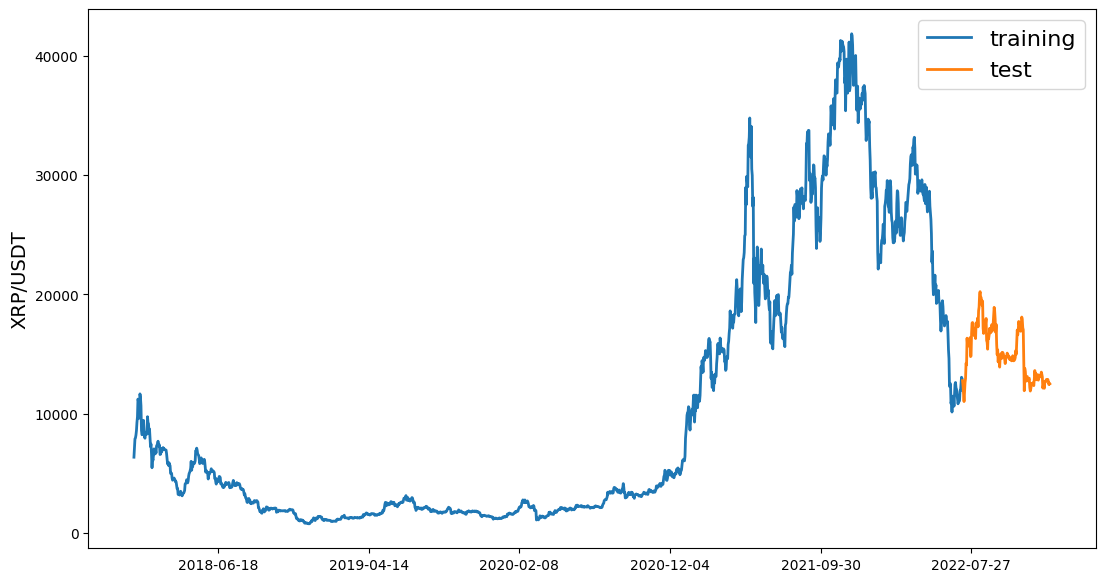

In [243]:
line_plot(train_data[aim], test_data[aim], 'training', 'test', title='')

In [244]:
def normalise_zero_base(continuous):
    return continuous / continuous.iloc[0] - 1

def normalise_min_max(continuous):
    return (continuous - continuous.min()) / (data.max() - continuous.min())

In [245]:

def extract_window_data(continuous, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(continuous) - window_len):
        tmp = continuous[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)
def prepare_data(continuous, aim, window_len=10, zero_base=True, test_size=0.2):
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[aim][window_len:].values
    y_test = test_data[aim][window_len:].values
    if zero_base:
        y_train = y_train / train_data[aim][:-window_len].values - 1
        y_test = y_test / test_data[aim][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [246]:

def build_lstm_model(input_data, output_size, neurons, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model
np.random.seed(245)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 50
epochs = 40
batch_size = 32
loss = 'mse'
dropout = 0.24
optimizer = 'adam'
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(
    data, aim, window_len=window_len, zero_base=zero_base, test_size=test_size)
     

In [247]:
print(X_train.shape)

(1645, 5, 1)


In [248]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
modelfit = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
     

Epoch 1/40


/mnt/c/Users/aras/python_iths/iths_2023_sep_dec/aras_venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0097 - val_loss: 0.0032
Epoch 2/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - val_loss: 0.0028
Epoch 3/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - val_loss: 0.0024
Epoch 4/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 5/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 6/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 7/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 8/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 9/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 10/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 11/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 12/40
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - val_loss: 0.0016


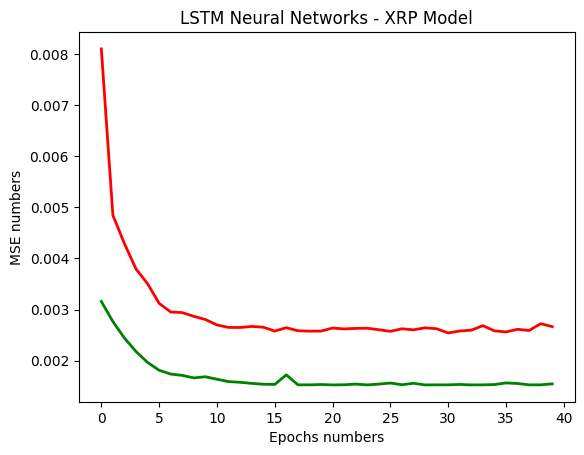

In [249]:
plt.plot(modelfit.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(modelfit.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM Neural Networks - XRP Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

In [250]:
targets = test_data[aim][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


0.02865227022266376

In [251]:
from sklearn.metrics import mean_squared_error
SCORE_MSE=mean_squared_error(preds, y_test)
SCORE_MSE

0.0017309343576423421

In [252]:
from sklearn.metrics import r2_score
r2_score=r2_score(y_test, preds)
r2_score*100

79.8419305497151

[11749.74941921 12643.32424736 13033.51831639 14218.47343993
 14156.00257885 16304.72243607 15881.17825341 15726.51636052
 16095.41292739 15830.36701584 15933.30622888 16439.97418475
 14998.5779779  14870.75733083 16698.53694677 17730.18918622
 17722.29872894 17263.17509961 17221.26752734 16686.49549484
 16865.72212476 16686.83175659 16404.21135068 17625.0356853
 17429.26172614 17440.76448631 18064.57281923 17448.99869925
 18634.16702235 19061.35012388 20070.4295218  20317.46498108
 19901.07616997 19831.05247736 19569.24081624 19196.14057302
 19513.76024336 17416.82159454 16768.06858397 17199.56258017
 17451.93356395 17810.48805428 17707.58820868 18053.75785398
 16364.74182987 16022.61637706 15499.94645292 16536.77741665
 16429.62721014 16661.69064832 17208.31442332 17111.29896665
 16874.43663025 17171.40896106 17535.7327559  17051.78327656
 17498.98300242 17615.49264765 18325.11657679 18998.37311268
 18769.01669168 18049.14756703 16969.15972608 17477.18357491
 16034.90110677 15040.059

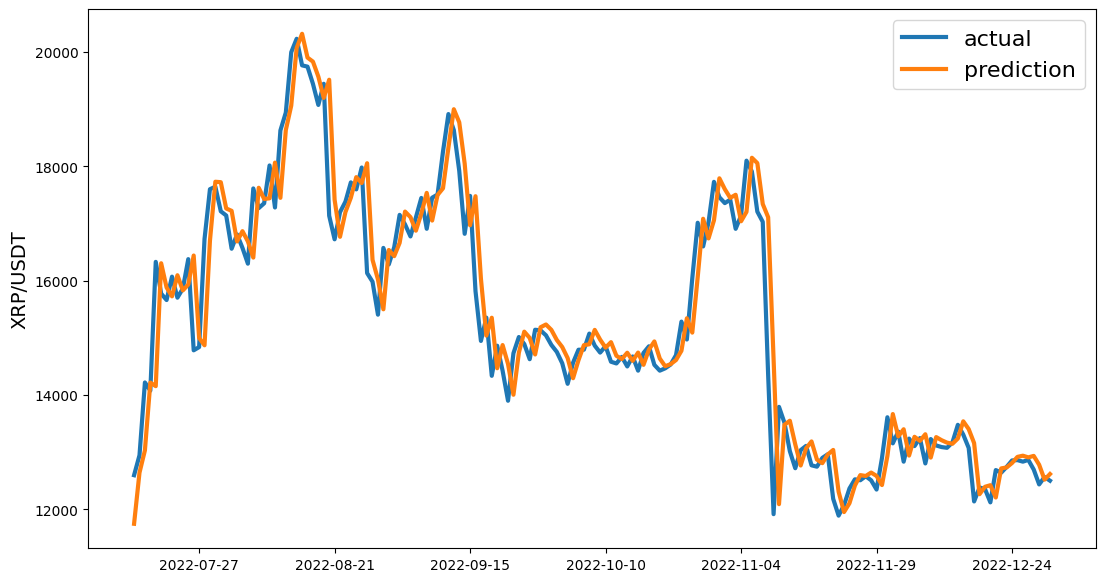

In [253]:
preds = test_data[aim].values[:-window_len] * (preds + 1)
print(preds)  
preds = pd.Series(index=targets.index, data=preds)
print(preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [254]:
print(targets.index[-1])

2022-12-31 00:00:00


In [255]:
print(preds.index[-1])

2022-12-31 00:00:00


In [256]:
# Lägg till en dag till det sista datumet
future_date = targets.index[-1] + pd.Timedelta(days=1)

In [257]:
print(future_date)

2023-01-01 00:00:00


In [258]:
future_prediction = model.predict(X_test[-1:])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [259]:
print(future_prediction)

[[-0.01686878]]


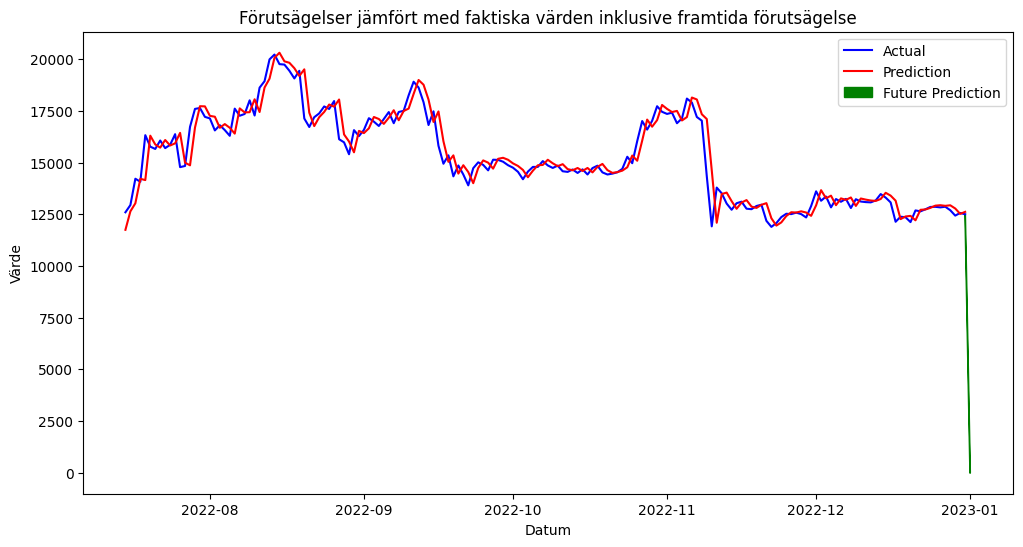

In [262]:
import pandas as pd
import matplotlib.pyplot as plt

# Lägg till en dag till det sista datumet
#future_date = targets.index[-1] + pd.Timedelta(days=1)

# Skapa en pandas Series för framtida förutsägelse
future_prediction_series = pd.Series(index=[future_date], data=future_prediction.flatten())

# Plot förutsägelser och målvariabler
plt.figure(figsize=(12, 6))
plt.plot(targets.index, targets, label='Actual', color='blue')  # faktiska värden
plt.plot(preds.index, preds, label='Prediction', color='red')  # förutsägelser

# Plotta också future_prediction
#plt.plot(future_prediction_series.index, future_prediction_series, 'ro', label='Future Prediction')  # framtida förutsägelse

# Plotta en pil för att visa den framtida förutsägelsen
plt.arrow(targets.index[-1], targets.iloc[-1], 1, future_prediction_series.values[0] - targets.iloc[-1], 
width=0.1, head_width=0.3, head_length=0.2, color='green', label='Future Prediction')

# Ställ in etiketter och titel
plt.xlabel('Datum')
plt.ylabel('Värde')
plt.title('Förutsägelser jämfört med faktiska värden inklusive framtida förutsägelse')
plt.legend()

# Visa plotten
plt.show()







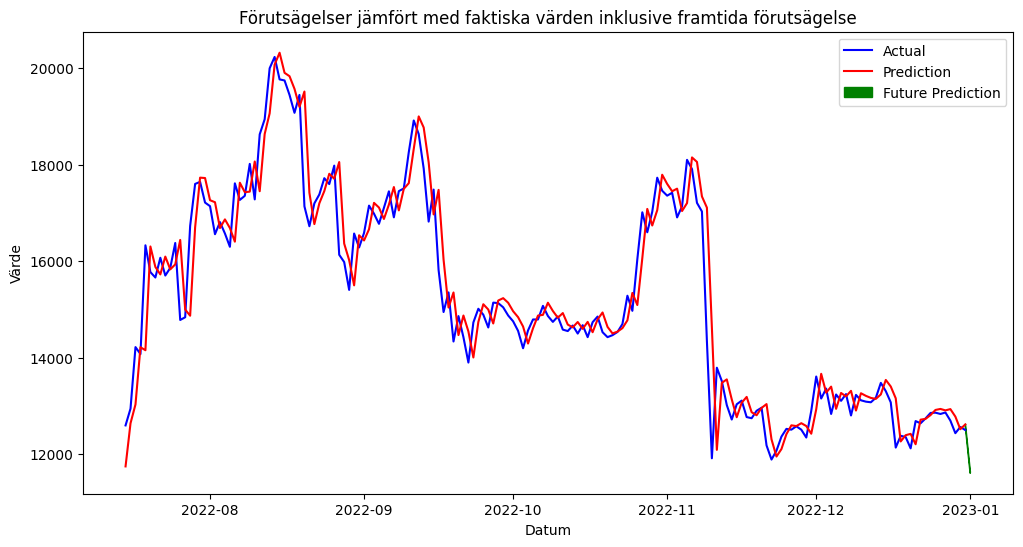

In [266]:
import pandas as pd
import matplotlib.pyplot as plt

# Lägg till en dag till det sista datumet
future_date = targets.index[-1] + pd.Timedelta(days=1)

# Skapa en pandas Series för framtida förutsägelse
future_prediction_series = pd.Series(index=[future_date], data=future_prediction.flatten())

# Plot förutsägelser och målvariabler
plt.figure(figsize=(12, 6))
plt.plot(targets.index, targets, label='Actual', color='blue')  # faktiska värden
plt.plot(preds.index, preds, label='Prediction', color='red')  # förutsägelser

# Bestäm startpositionen för pilen (där förutsägelsen slutar)
start_x = targets.index[-1]
start_y = preds.iloc[-1]

# Bestäm slutpositionen för pilen (en viss längd ner på y-axeln från startpositionen)
end_x = start_x + pd.Timedelta(days=1)
end_y = start_y - 1000.0  # Justera detta värde för att ändra längden på pilen

# Plotta pilen för att visa den framtida förutsägelsen
plt.arrow(start_x, start_y, 1, end_y - start_y, 
          width=0.1, head_width=0.3, head_length=0.2, color='green', label='Future Prediction')

# Ställ in etiketter och titel
plt.xlabel('Datum')
plt.ylabel('Värde')
plt.title('Förutsägelser jämfört med faktiska värden inklusive framtida förutsägelse')
plt.legend()

# Visa plotten
plt.show()


/tmp/ipykernel_14586/1146639579.py:5: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_index = pd.date_range(start=preds.index[-1], periods=2, closed='right')[-1]  # Välj det sista datumet i perioden
/tmp/ipykernel_14586/1146639579.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  future_prediction_series = pd.Series(index=[future_index])
/tmp/ipykernel_14586/1146639579.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  extended_targets = targets.append(pd.Series(index=[future_index]))
/tmp/ipykernel_14586/1146639579.py:12: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  extended_targets = targets.append(pd.Series(index=[future_index]

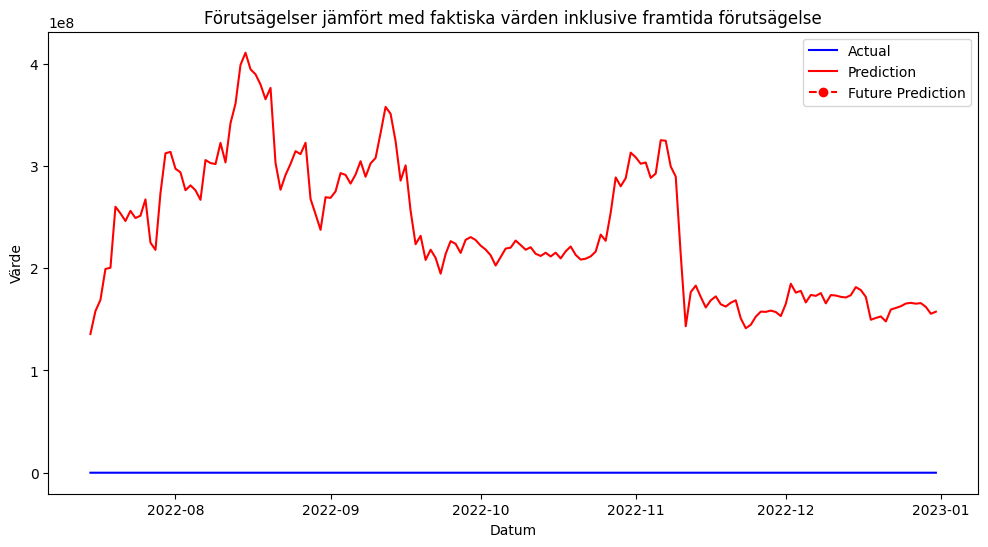

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Skapa en pandas Series för future_prediction med ett enskilt värde och det nya indexet
future_index = pd.date_range(start=preds.index[-1], periods=2, closed='right')[-1]  # Välj det sista datumet i perioden
future_prediction_series = pd.Series(index=[future_index])

# Konvertera future_prediction_series till en DataFrame med rätt namn på kolumnen
future_prediction_df = future_prediction_series.to_frame(name='Prediction')

# Utöka targets för att inkludera det nya framtida datumet
extended_targets = targets.append(pd.Series(index=[future_index]))

# Plot förutsägelser och målvariabler
plt.figure(figsize=(12, 6))
plt.plot(extended_targets.index, extended_targets, label='Actual', color='blue')  # faktiska värden
plt.plot(preds.index, preds, label='Prediction', color='red')  # förutsägelser

# Plotta också future_prediction som en förlängning av Prediction
plt.plot(future_prediction_df.index, future_prediction_df['Prediction'], 'ro--', label='Future Prediction')  # framtida förutsägelse

# Ställ in etiketter och titel
plt.xlabel('Datum')
plt.ylabel('Värde')
plt.title('Förutsägelser jämfört med faktiska värden inklusive framtida förutsägelse')
plt.legend()

# Visa plotten
plt.show()







In [ ]:
print(extended_targets)

2022-07-15    12599.0
2022-07-16    12947.0
2022-07-17    14221.0
2022-07-18    14077.0
2022-07-19    16329.0
               ...   
2022-12-28    12698.0
2022-12-29    12438.0
2022-12-30    12567.0
2022-12-31    12503.0
2023-01-01        NaN
Length: 171, dtype: float64
